In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import xarray

In [5]:
data_path = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/projects/photon_calibration/photon_calibration_in_readout_110203/dataset.nc"

data = xarray.open_dataset(data_path)
data

<xarray.Dataset>
Dimensions:                                  (sweep_1: 125, sample: 100, sweep_0: 50, sweep_2: 2)
Coordinates:
    pulse_frequency                          (sweep_1) float64 ...
    pulse_frequency_if_trans                 (sweep_1) int32 ...
  * sample                                   (sample) int32 0 1 2 3 ... 97 98 99
    resonator_drive_amplitude_scaling        (sweep_0) float64 ...
    resonator_drive_amplitude_scaling_trans  (sweep_0) float64 ...
    pulse_amplitude_scaling                  (sweep_2) int32 ...
    pulse_amplitude_scaling_trans            (sweep_2) float64 ...
Dimensions without coordinates: sweep_1, sweep_0, sweep_2
Data variables:
    readout__final__I__avg                   (sweep_2, sweep_1, sweep_0) float64 ...
    readout__final__I__avg__error            (sweep_2, sweep_1, sweep_0) float64 ...
    readout__final__Q__avg                   (sweep_2, sweep_1, sweep_0) float64 ...
    readout__final__Q__avg__error            (sweep_2, sweep_1, sweep_0) float64 ...
    readout__final__abs__avg                 (sweep_2, sweep_1, sweep_0) float64 ...
    readout__final__abs__avg__error          (sweep_2, sweep_1, sweep_0) float64 ...
    readout__final__phase__avg               (sweep_2, sweep_1, sweep_0) float64 ...
    readout__final__phase__avg__error        (sweep_2, sweep_1, sweep_0) float64 ...
    readout_lines[0].flattop_plateau         float64 ...
    readout_lines[0].flattop_wait_after      float64 ...
    elapsed_time                             float64 ...
    samples                                  int32 ...
Attributes:
    experiment_name:  photon_calibration_in_readout
    datetime_start:   2023-10-06-11-02-03
    datetime_end:     2023-10-06-11-03-09
    datetime_format:  year-month-day-hour-minute-second
    data_version:     0.0.2
    qubit_indicies:   0
    file_id:          20231006110203

In [38]:
no_x_gate = data.readout__final__abs__avg[0]
w_x_gate = data.readout__final__abs__avg[1]

no_x_gate_err = data.readout__final__abs__avg__error[0]
w_x_gate_err = data.readout__final__abs__avg__error[1]

freq = data.pulse_frequency
amp = data.resonator_drive_amplitude_scaling


[Text(0.5, 0, 'Drive Amplitude'),
 Text(0, 0.5, 'Drive Frequency'),
 Text(0.5, 1.0, 'With X Gate')]

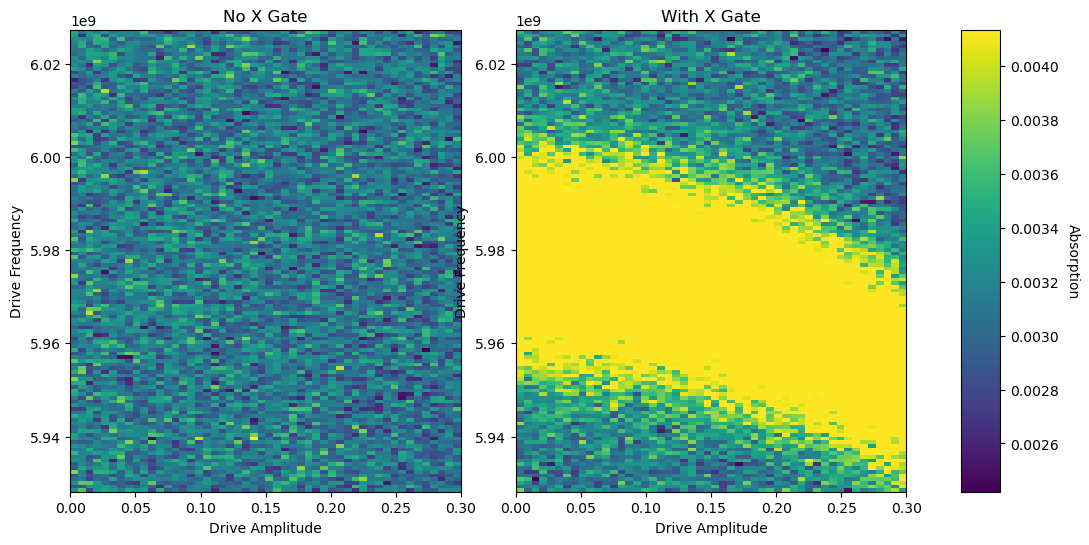

In [39]:
fig, ax = plt.subplots(ncols = 3, figsize = (12, 6), gridspec_kw={"width_ratios":[1, 1, 0.1]})

vmin, vmax = np.min(no_x_gate.data), np.max(no_x_gate.data)
ax[0].imshow(no_x_gate.data, origin = "lower", vmin = vmin, vmax = vmax, aspect = "auto", extent = [amp[0], amp[-1], freq[0], freq[-1]])
img = ax[1].imshow(w_x_gate.data, origin = "lower", vmin = vmin, vmax = vmax, aspect = "auto", extent = [amp[0], amp[-1], freq[0], freq[-1]])

cbar = fig.colorbar(img, cax = ax[2])
cbar.set_label("Absorption", rotation = 270, labelpad = 15)

ax[0].set(
    xlabel = "Drive Amplitude",
    ylabel = "Drive Frequency",
    title = "No X Gate"
)
ax[1].set(
    xlabel = "Drive Amplitude",
    ylabel = "Drive Frequency",
    title = "With X Gate"
)

[Text(0.5, 0, 'Drive Amplitude'),
 Text(0, 0.5, 'Drive Frequency'),
 Text(0.5, 1.0, 'Difference between no X gate and with X gate')]

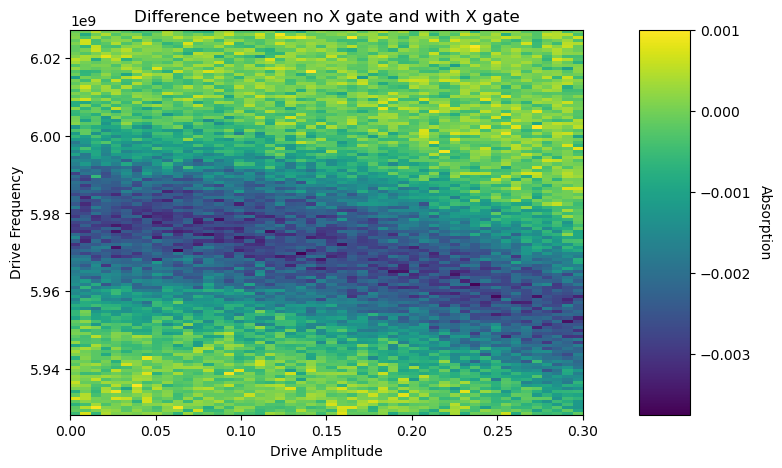

In [40]:
fig, ax = plt.subplots(ncols = 2, gridspec_kw={"width_ratios":[1, 0.1]}, figsize = (8, 5))
img = ax[0].imshow(no_x_gate - w_x_gate, aspect = "auto", origin = "lower", extent = [amp[0], amp[-1], freq[0], freq[-1]])
cbar = fig.colorbar(img, cax = ax[1])
cbar.set_label("Absorption", rotation = 270, labelpad = 15)

ax[0].set(
    xlabel = "Drive Amplitude",
    ylabel = "Drive Frequency",
    title = "Difference between no X gate and with X gate"
)

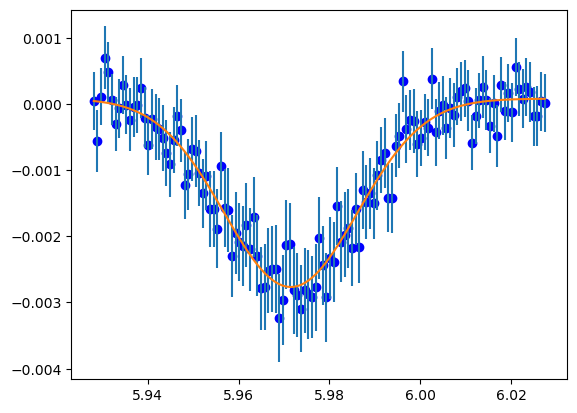

In [41]:
diff = no_x_gate - w_x_gate
diff_errs = np.sqrt(no_x_gate ** 2 + w_x_gate ** 2) / np.sqrt(data.samples.values)
plt.plot(freq*1e-9, diff[:, 25], "bo")
plt.errorbar(freq*1e-9, diff[:, 25], diff_errs[:, 25], ls = "none")

from scipy.stats import norm

func = lambda x, const, ampltiude, mean, sigma: const - ampltiude * norm.pdf(x, mean, sigma) 

from scipy.optimize import curve_fit
val, cov = curve_fit(func, freq* 1e-9, diff[:, 25], p0 = [0, -0.001, 5.98, 0.01], sigma = diff_errs[:, 25], absolute_sigma=True) 

plt.plot(freq* 1e-9, func(freq * 1e-9, *val))

# plt.title("Fit of the difference at 0 amplitude")
# plt.xlabel("Drive Frequency [GHz]")
# plt.ylabel("Absorption")

In [42]:
from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm import tqdm

diff = no_x_gate - w_x_gate
diff_errs = np.sqrt(no_x_gate ** 2 + w_x_gate ** 2)

func = lambda x, const, ampltiude, mean, sigma: const - ampltiude * norm.pdf(x, mean, sigma) 

def calculate_dip_location(xdata, ydata, yerror):
    p0 = [ydata.mean(), ydata.std(), xdata[ydata.argmin()], 0.05]
    try:
        val, cov = curve_fit(func, xdata, ydata,  p0 = p0, sigma = yerror, absolute_sigma=True)
        return val[2], cov[2, 2]
    except RuntimeError:
        return np.nan, np.nan

dip_mean, dip_mean_error = [], []

for i, _ in enumerate(amp):
    mu, mu_err = calculate_dip_location(freq * 1e-9, diff[:, i], diff_errs[:, i])
    dip_mean.append(mu)
    dip_mean_error.append(mu_err)

dip_mean = np.array(dip_mean)
dip_mean_error = np.array(dip_mean_error)

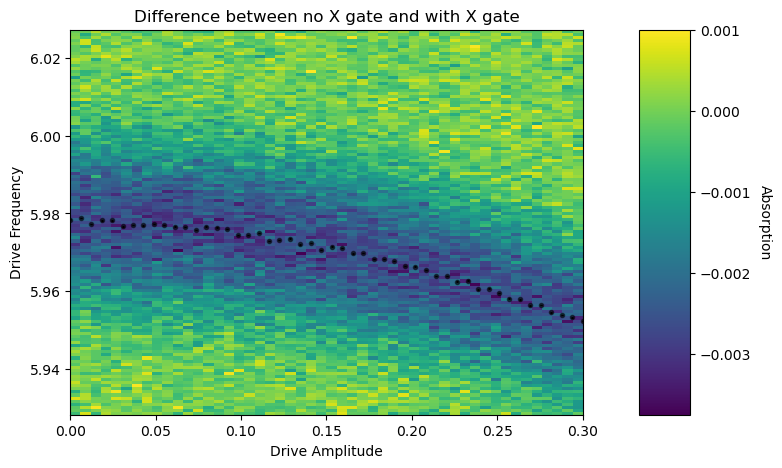

In [43]:
fig, ax = plt.subplots(ncols = 2, gridspec_kw={"width_ratios":[1, 0.1]}, figsize = (8, 5))
img = ax[0].imshow(no_x_gate - w_x_gate, aspect = "auto", origin = "lower", extent = [amp[0], amp[-1], freq[0], freq[-1]])
cbar = fig.colorbar(img, cax = ax[1])
cbar.set_label("Absorption", rotation = 270, labelpad = 15)

ax[0].set(
    xlabel = "Drive Amplitude",
    ylabel = "Drive Frequency",
    title = "Difference between no X gate and with X gate"
)

mask = ~np.isnan(np.array(dip_mean))

ax[0].imshow(diff.data, extent = [amp.min(), amp.max(), freq.min()*1e-9, freq.max()*1e-9], origin="lower", aspect = "auto")

ax[0].autoscale(False)

ax[0].errorbar(amp.data[mask], dip_mean[mask], dip_mean_error[mask], color = "black", capsize = 1, elinewidth = 1, ls = "none")
ax[0].plot(amp, dip_mean, "black", marker = ".", linestyle = "None", alpha = 0.5)



## Photon number at given ampltiude

In [55]:
# From calculation in other file
dispersive_shift = 720_000e-9
dispersive_shift_error = 0.02e-3

# Qubit Frequency from config file
qubit_frequency = 5978147892.0e-9



<ErrorbarContainer object of 3 artists>

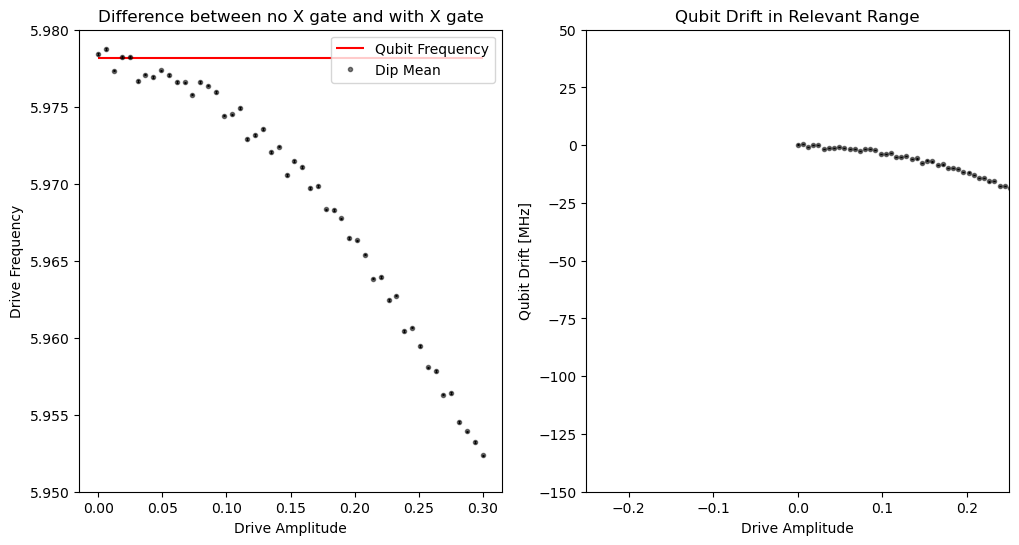

In [56]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))

ax[0].set(
    xlabel = "Drive Amplitude",
    ylabel = "Drive Frequency",
    title = "Difference between no X gate and with X gate",
    ylim = [5.950, 5.980]
)

mask = ~np.isnan(np.array(dip_mean))

ax[0].hlines(qubit_frequency, amp.min(), amp.max(), color = "red", label = "Qubit Frequency")
ax[0].plot(amp, dip_mean, "black", marker = ".", linestyle = "None", alpha = 0.5, label = "Dip Mean")

ax[0].errorbar(amp.data[mask], dip_mean[mask], dip_mean_error[mask], color = "black", capsize = 1, elinewidth = 1, ls = "none")

ax[0].legend()

ax[1].set(
    xlabel = "Drive Amplitude",
    ylabel = "Qubit Drift [MHz]",
    title = "Qubit Drift in Relevant Range",
    xlim = [-0.25, .25],
    ylim = [-150, 50],
)

ax[1].plot(amp, (dip_mean - qubit_frequency) * 1e3, "black", marker = ".", linestyle = "None", alpha = 0.5, label = "Dip Mean")
ax[1].errorbar(amp.data[mask], (dip_mean[mask] - qubit_frequency) * 1e3, dip_mean_error[mask] * 1e3, color = "black", capsize = 1, elinewidth = 1, ls = "none")

(-0.4, 0.4)

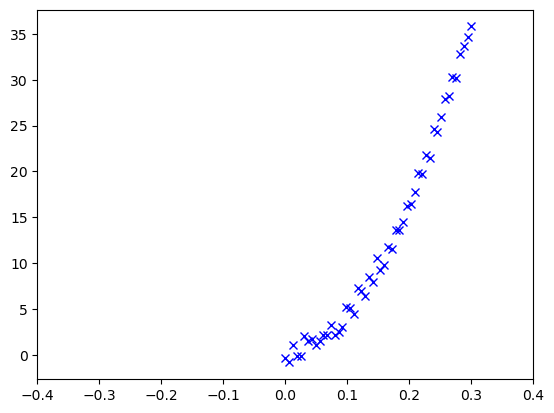

In [57]:
qubit_drift = (dip_mean - qubit_frequency)
qubit_drift_error = dip_mean_error

photon_count = - qubit_drift / dispersive_shift
photon_count_error = np.sqrt((qubit_drift_error / dispersive_shift) ** 2 + (qubit_drift * dispersive_shift_error / dispersive_shift ** 2) ** 2)

plt.plot(amp, photon_count, "bx")
plt.xlim(-0.40, 0.40)

<ErrorbarContainer object of 3 artists>

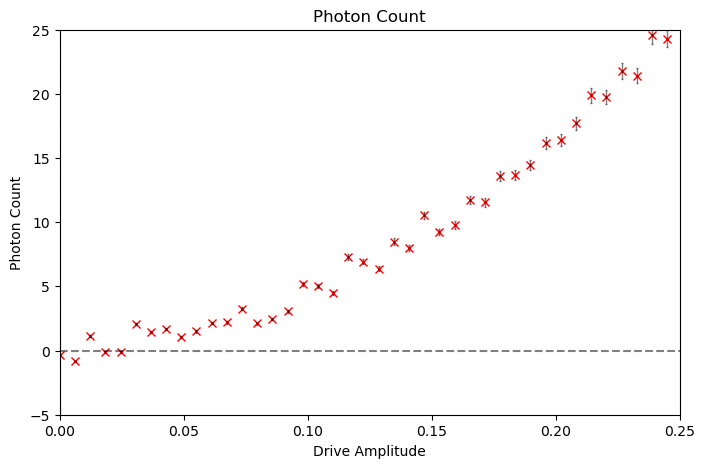

In [60]:
fig, ax = plt.subplots(ncols = 1, figsize = (8, 5))

ax.set(
    xlabel = "Drive Amplitude",
    ylabel = "Photon Count",
    title = "Photon Count",
    ylim = [-5, 25],
    xlim = [0, .25],
)

ax.plot(amp, photon_count, "rx", label = "Photon Count")


ax.hlines(0, amp.min(), amp.max(), color = "black", ls = "--", alpha = 0.5)
ax.vlines(0, *ax.get_ylim(), color = "black", ls = "--", alpha = 0.5)

ax.errorbar(amp.data[mask], photon_count[mask], photon_count_error[mask], color = "black", capsize = 1, elinewidth = 1, ls = "none", alpha = 0.50)